# Part 2 - Model building and selection

This notebook is part 2 of the capstone project from the [IBM AI Enterprise Workflow specialization](https://www.coursera.org/specializations/ibm-ai-workflow). The main goal here is to compare different models to predict revenue, given the [data](https://github.com/aavail/ai-workflow-capstone), and select one to be put into production.

Author: Rafael da Ponte Barbosa

UK, EIRE, Germany
Since we're aiming for a 30-day prediction, we'll leave the last month (June) out, as test, in the split

In [116]:
import pandas as pd
import numpy as np
import os
#import re
#import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

plt.style.use('seaborn')

from application.utils.ingestion import fetch_data,fetch_ts
from application.utils.processing import convert_to_ts, engineer_features

from application.utils.plot import ts_plot, ts_plot_pred

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
data_dir = os.path.join("data","cs-train")
ts_data = fetch_ts(data_dir)

... loading ts data from files


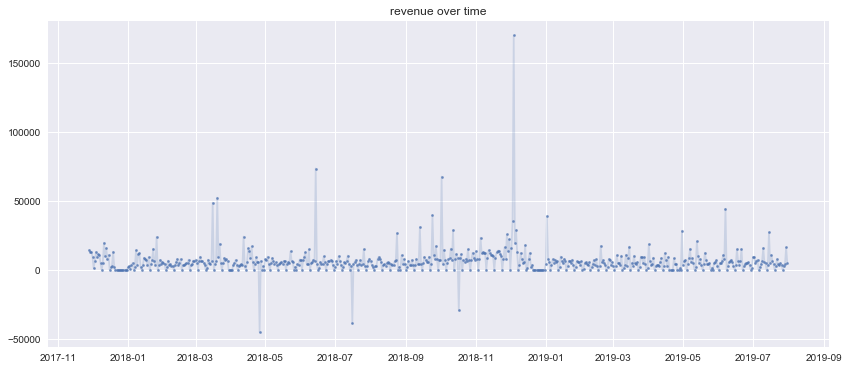

In [87]:
ts_plot(ts_data['all'].date, ts_data['all'].revenue,figx=14,figy=6, title="revenue over time")

## Baseline

We'll use a simple moving average as the baseline for forecasting.

In [114]:
ts_data.keys()

dict_keys(['all', 'eire', 'france', 'germany', 'hong_kong', 'netherlands', 'norway', 'portugal', 'singapore', 'spain', 'united_kingdom'])

In [129]:
windows = [7,14,28]
keys = ['all', 'united_kingdom', 'eire', 'germany']
results = []

for window in windows:
    print("Using window {}".format(window))
    mse = []
    
    for key in keys:
        df = ts_data[key]
        df_train = ts_data[key][:-30]
        df_test = ts_data[key][-30:].copy()

        y_pred = df_train.revenue.values

        for date in df_test.date:
            y_pred = np.append(y_pred, np.mean(y_pred[-window:]))

        df_test['pred'] = y_pred[-30:]
        
        mse.append(mean_squared_error(df_test.revenue, df_test.pred))

    results.append(np.mean(mse))
    print("Average MSE: {}".format(results[-1]))
    

Using window 7
Average MSE: 16595181.022210326
Using window 14
Average MSE: 15829939.271474602
Using window 28
Average MSE: 14897365.436453233


In [134]:
window = 28
keys = ['all', 'united_kingdom', 'eire', 'germany']
mse_baseline = {}
y_pred = {}

for key in keys:
    df = ts_data[key]
    df_train = ts_data[key][:-30]
    df_test = ts_data[key][-30:].copy()

    y_pred[key] = df_train.revenue.values

    for date in df_test.date:
        y_pred[key] = np.append(y_pred[key], np.mean(y_pred[key][-window:]))

    df_test['pred'] = y_pred[key][-30:]
    
    mse_baseline[key] = mean_squared_error(df_test.revenue, df_test.pred)

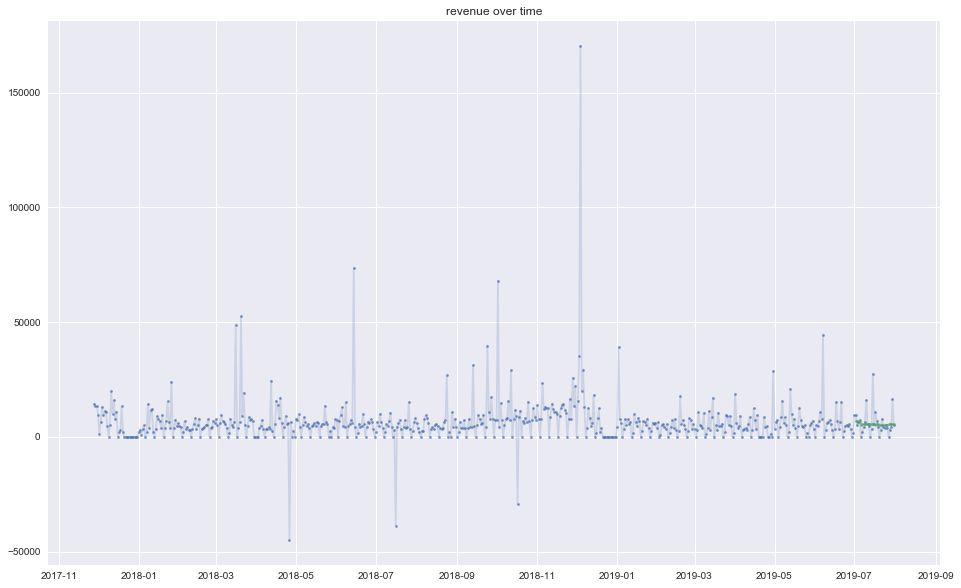

In [142]:
ts_plot_pred(ts_data['all'].date, ts_data['all'].revenue,\
             ts_data['all'][-30:].date, y_pred['all'][-30:], figx=16,figy=10, title="revenue over time")

In [91]:
df.date.max()

Timestamp('2019-07-31 00:00:00')

In [89]:
df[df.date<'2019-06']

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.00
1,2017-11-02,0,0,0,0,2017-11,0.00
2,2017-11-03,0,0,0,0,2017-11,0.00
3,2017-11-04,0,0,0,0,2017-11,0.00
4,2017-11-05,0,0,0,0,2017-11,0.00
...,...,...,...,...,...,...,...
572,2019-05-27,0,0,0,0,2019-05,0.00
573,2019-05-28,1281,62,743,6671,2019-05,5080.38
574,2019-05-29,1456,65,826,5626,2019-05,5831.20
575,2019-05-30,1588,86,879,7871,2019-05,7065.06


In [92]:
for country,df in ts_data.items():
    print(country)
    print(df.date.min(),df.date.max())

all
2017-11-28 00:00:00 2019-07-31 00:00:00
eire
2017-11-28 00:00:00 2019-07-28 00:00:00
france
2017-11-28 00:00:00 2019-07-31 00:00:00
germany
2017-11-28 00:00:00 2019-07-31 00:00:00
hong_kong
2018-04-18 00:00:00 2019-06-19 00:00:00
netherlands
2017-11-29 00:00:00 2019-07-17 00:00:00
norway
2017-12-04 00:00:00 2019-07-19 00:00:00
portugal
2017-11-28 00:00:00 2019-07-31 00:00:00
singapore
2018-04-24 00:00:00 2019-07-15 00:00:00
spain
2017-11-30 00:00:00 2019-07-25 00:00:00
united_kingdom
2017-11-28 00:00:00 2019-07-31 00:00:00


In [33]:
df

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.00
1,2017-11-02,0,0,0,0,2017-11,0.00
2,2017-11-03,0,0,0,0,2017-11,0.00
3,2017-11-04,0,0,0,0,2017-11,0.00
4,2017-11-05,0,0,0,0,2017-11,0.00
...,...,...,...,...,...,...,...
602,2019-06-26,1274,62,965,5702,2019-06,4611.00
603,2019-06-27,1487,72,897,8230,2019-06,5128.02
604,2019-06-28,923,62,565,4674,2019-06,3096.20
605,2019-06-29,0,0,0,0,2019-06,0.00
